# Deep Learning for NLP 

INCLUDE:
- Text Preprocessing
  - Tokenization: 分词
  - Encoding Text: 将文本转换为整数序列
  - Padding & Truncating: 填充和截断
  - Converting to DataLoader: 将数据集转换为DataLoader对象
  - Word Embeddings: 词嵌入
    - Pre-trained Word Embeddings
- Neural Network Models



与逻辑回归一样，神经网络也是辨别模型：它们直接学习分类任务，而无需学习生成文本。但与逻辑回归不同的是，它们可以对输入的非线性函数进行建模。这是通过具有非线性激活函数的隐藏层来实现的。

神经网络的一些主要优势可归纳如下：
   * 它可以模拟非线性函数，因此可以处理特征和类标签之间更为复杂的关系。
   * 它可以进行表征学习：隐藏层可以学习如何从低层数据中提取特征。
   * 它可以处理标记序列--我们不必像逻辑回归那样，用单一的特征向量来表示文档。

另一方面，它的缺点是
   * 训练和测试的成本要高得多。
   * 对小数据集可能会产生严重的过拟合。
   * 隐藏层学习到的特征可能难以解释，这就很难预测模型的行为，例如它可能在哪种情况下失败。
   * 泛化是不可预测的：当应用于训练集分布之外的测试数据时，它们有时会有意想不到的表现。

### 0.1 一般NLP任务数据预处理的最佳实践：

1. **建立字典（Vocabulary）**：从文档集合中识别所有唯一的词汇，并为每个词汇分配一个唯一的整数索引。这个字典使得模型能够处理文本数据。

2. **文本到整数序列的映射**：使用字典将每个文档中的单词转换为对应的整数索引。这一步将文本数据转换为神经网络能够处理的数值形式。

3. **截断和填充**：由于神经网络需要输入固定长度的向量，因此需要将所有文档长度统一。这通常通过截断较长的文档和/或为较短的文档添加填充值（如0）来实现。

4. **转换为Tensor**：将处理过的整数序列转换为PyTorch的Tensor格式，这是PyTorch模型的输入格式。

5. **DataLoader使用**：为了有效地训练模型，使用PyTorch的`DataLoader`类将数据批量化，并可选地在训练过程中对数据进行打乱和并行处理。

一些额外的最佳实践包括：

- **预训练词嵌入**：在某些情况下，使用预训练的词嵌入（如GloVe或Word2Vec）作为模型的初始权重可以提高性能，特别是当可用的训练数据量不大时。

- **高级文本编码方法**：对于复杂的NLP任务，考虑使用如BERT、GPT或其他Transformer架构的预训练模型，这些模型能够捕获文本中的深层次语义关系，并且可以微调以适应特定的任务。

- **注意力机制和序列模型**：对于需要捕捉长距离依赖的任务（如机器翻译或文本生成），使用LSTM、GRU或Transformer模型可以获得更好的结果。

### 0.2 Embedding Layer
在pytorch中，一般直接使用在定义神经网络类的层时，使用`nn.Embedding`来实现词嵌入。嵌入层的权重是随机初始化的，随后在训练过程中学习。这样，模型就可以学习到一个针对特定任务优化的词嵌入。




### 0.3 Pre-trained Word Embeddings
除了直接使用nn.Embedding层进行嵌入，还可以使用预训练的词嵌入（如GloVe、Word2Vec等）来初始化模型的词嵌入层。这种方法通常可以提高模型的性能，特别是在训练数据有限的情况下。

在PyTorch框架下使用预训练的词嵌入（如GloVe、Word2Vec等）涉及到几个步骤，从加载预训练词向量，创建嵌入层，到将这些预训练向量加载到模型中。以下是一个概括的最佳实践步骤和相应的代码实现：

#### 步骤

1. **加载预训练词向量**：首先，需要从预训练模型中加载词向量。这通常意味着加载一个大型的文件，其中包含了大量单词及其对应的向量表示。

2. **创建词汇表**：基于你的训练数据，创建一个词汇表，确保每个单词都有一个唯一的整数索引。

3. **初始化嵌入矩阵**：首先，创建一个零矩阵或随机初始化的矩阵，其形状为`(len(dictionary), embedding_dim)`，其中`embedding_dim`是GloVe向量的维度（对于`glove-twitter-25`，维度是25）。

4. **填充嵌入矩阵**：遍历`dictionary`中的每个词汇，如果该词汇在`glove_wv`中有对应的向量，就将这个向量复制到嵌入矩阵中对应的行；如果没有找到，就保留零向量或随机向量。

5. **创建嵌入层**：在PyTorch模型中创建一个`nn.Embedding`层，其大小和预训练词向量相匹配。

6. **加载嵌入矩阵到嵌入层**：将准备好的嵌入矩阵加载到`nn.Embedding`层中，这通常通过替换嵌入层的权重实现。







In [1]:
import numpy as np
import torch
from datasets import load_dataset
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import word2vec
from gensim.utils import tokenize
import gensim.downloader
import matplotlib.pyplot as plt

# - `%load_ext autoreload` 是一个魔术命令，用于加载或重新加载扩展。在这个例子中，它加载了`autoreload`扩展。这个扩展允许Jupyter自动检测模块代码的更改，并在不需要重启笔记本的情况下，自动重新加载这些模块。
# 
# - `%autoreload 2` 是设置`autoreload`模式的命令，其中`2`表示一种特定的自动重新加载策略。具体来说，`2`表示在执行任何代码之前，自动重新加载所有标记的模块。这意味着只要你在笔记本中运行任何代码片段，它就会自动检查并重新加载自上次导入以来已经更改的所有模块。
%load_ext autoreload 
%autoreload 2 

# 1. Load a Dataset


首先，我们将加载 `tweets hate speech` 数据集。当使用`name=sentiment`时，我们将加载一个包含三个类别的数据集，其中 0表示负面言论，1表示中性言论，2表示正面言论。该数据集常用于情感分析任务。

In [2]:
cache_dir = "./data_cache"

dataset = load_dataset(
    "tweet_eval",
    name="sentiment",
    cache_dir=cache_dir,
)

train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

print(f"Training dataset with {len(train_dataset)} instances loaded")
print(f"Development/validation dataset with {len(val_dataset)} instances loaded")
print(f"Test dataset with {len(test_dataset)} instances loaded")

Training dataset with 45615 instances loaded
Development/validation dataset with 2000 instances loaded
Test dataset with 12284 instances loaded


In [9]:
train_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 45615
})

# 2. Preprocess the Data



对于我们的数据集，我们将执行以下预处理步骤：

- tok_text: 将文本分词为单词，会去掉标点符号和空格
- encode_text: 将文本转换为token对应的ID（索引+1）。因为要将0用于填充，所以索引从1开始.需要先建立一个Dictionary，将单词映射到索引
- pad_text: 当文档长度小于最大长度时，用0填充文档；当文档长度大于最大长度时，截断文档
- convert_to_data_loader: 将数据集转换为DataLoader对象，以便使用小批量随机梯度下降进行学习

在pytorch中，一般直接使用在定义神经网络类的层时，使用`nn.Embedding`来实现词向量转换。

## 2.1 Tokenize the Text
对于dataset对象，添加一个新的键值对，即tokens，其中包含文本的分词结果。

In [3]:
from gensim.utils import tokenize

# tokenize函数：将文本分词为单词，会去掉标点符号和空格
def tok_text(sample):
    sample["tokens"] = list(tokenize(sample['text']))
    return sample

tok_train_dataset = train_dataset.map(tok_text)
tok_val_dataset = val_dataset.map(tok_text)
tok_test_dataset = test_dataset.map(tok_text)

tok_train_dataset

Dataset({
    features: ['text', 'label', 'tokens'],
    num_rows: 45615
})

## 2.2 Encode the Text
对于dataset对象，添加一个新的键值对，即encoded，将分词的每个词使用建立好的Dictionary映射到整数索引。由于需要使用0来填充，所以索引从1开始。

建立Dictionary一般只使用训练集，因为测试集和验证集可能包含未知的单词。通过这种方式，我们可以确保模型不会在训练集之外的单词上进行训练。当在测试集上进行预测时，我们可以使用`<UNK>`标记来表示未知的单词，提升模型的泛化能力。

对于未知词（Out-Of-Vocabulary, OOV）以及相关错误处理是NLP项目中的重要部分。在这里，我们将使用`<UNK>`标记来表示未知词。确保"<UNK>"键有一个默认值，比如0或任意整数。这确保了如果<UNK>不在字典中，则会添加它，并赋予一个明确的整数值。这个值应该是独一无二的，不与字典中其他词汇的值冲突。常见的做法是将其设置为当前字典大小的下一个整数，即`len(dictionary.token2id)`。


In [4]:
from gensim.corpora import Dictionary

# 构建Dictionary
dictionary = Dictionary(tok_train_dataset["tokens"]) # construct word<->id mappings - it does it in alphabetical order
print(len(dictionary)) # 53730 个单词

53730


In [5]:
# 如果"<UNK>"不在dictionary.token2id中，则添加它，并赋予一个独立的整数值
if "<UNK>" not in dictionary.token2id:
    dictionary.token2id["<UNK>"] = len(dictionary.token2id) # some_integer_value可以是任意整数，比如最大的id+1

def encode_text(sample):
    sample['input_ids'] = [dictionary.token2id.get(token, dictionary.token2id.get("<UNK>")) + 1 for token in sample['tokens']]
    return sample
# 在这个解决方案中，.get()方法尝试从dictionary.token2id获取token对应的id，如果失败，则返回<UNK>对应的id。

pre_train_dataset = tok_train_dataset.map(encode_text)
pre_test_dataset = tok_test_dataset.map(encode_text)
pre_val_dataset = tok_val_dataset.map(encode_text)

pre_train_dataset

Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'tokens', 'input_ids'],
    num_rows: 45615
})

## 2.3 Pad & Truncate 
由于神经网络要求输入的文档长度是固定的，我们需要对文档进行填充或截断。我们将选择合适的最大长度，并对小于该长度的文档进行0填充，对大于该长度的文档进行截断。

填充（Padding）可以发生在文档的开头（称为前置填充或pre-padding）或结尾（称为后置填充或post-padding），这取决于特定的应用场景和模型架构的要求。下面是两种情况的考虑因素：

#### 前置填充（Pre-padding）
- **序列处理的方向**：如果模型（如某些类型的循环神经网络RNN）从序列的末尾开始处理信息，则在序列开头进行填充可能更有意义。这样，模型首先遇到的是有效数据而不是填充数据，可能有助于效果的提升。
- **注意力机制**：在使用注意力机制的模型中，如果注意力可以更集中于序列的实际内容而非填充部分，则前置填充可能更优。
  
#### 后置填充（Post-padding）
- **序列处理的方向**：对于从序列开始处处理信息的模型（如标准的RNN），在序列的结尾添加填充可能更自然，因为这样可以确保模型在处理每个序列时首先遇到的是真实的数据点。
- **兼容性**：某些框架和库可能默认使用或优先支持后置填充，因此在没有特定需求的情况下遵循这些默认设置可以简化实现过程。


首先查看每个文档的长度分布，以便选择合适的最大长度。可以通过直方图来查看文档长度的分布。
下图可以看到，选择30作为最大长度是合适的。

本次实验会使用前置填充。在对`pre_train_dataset`等使用map方法添加`pad_text`函数后，可以得到`pad_train_dataset`等数据集。这些数据集保证了每个文档的`input_ids`长度都是30。

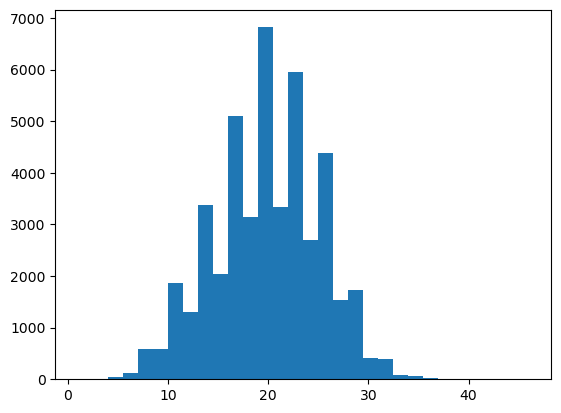

In [6]:
len_list = [len(sample['input_ids']) for sample in pre_train_dataset]
plt.hist(len_list, bins=30)
plt.show()

In [7]:
sequence_length = 30   # 选择30作为最大长度

def pad_text(sample):

    if len(sample['input_ids']) < sequence_length: # pre-pad
        sample['input_ids'] = [0] * (sequence_length - len(sample['input_ids'])) + sample['input_ids']
    elif len(sample['input_ids']) > sequence_length: # truncate
        sample['input_ids'] = sample['input_ids'][:sequence_length]
        
    return sample

pad_train_dataset = pre_train_dataset.map(pad_text)
pad_test_dataset = pre_test_dataset.map(pad_text)
pad_val_dataset = pre_val_dataset.map(pad_text)

Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

## 2.4 Convert to DataLoader
将数据集转换为DataLoader对象，以便使用小批量随机梯度下降进行学习。在这里，我们将使用PyTorch的DataLoader类，它允许我们迭代数据集并返回小批量数据。我们将使用DataLoader对象来训练和评估我们的模型。

In [8]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 64

# convert from the Huggingface format to a TensorDataset so we can use the mini-batch sampling functionality
def convert_to_data_loader(dataset, num_classes):
    # convert from list to tensor
    input_tensor = torch.from_numpy(np.array(dataset['input_ids'])) # 将input_ids转换为numpy数组，然后转换为tensor
    label_tensor = torch.from_numpy(np.array(dataset['label'])).long() # 将label转换为numpy数组，然后转换为tensor
    tensor_dataset = TensorDataset(input_tensor, label_tensor)
    loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

    return loader

num_classes = len(np.unique(pad_train_dataset["label"]))   # number of possible labels 

train_loader = convert_to_data_loader(pad_train_dataset, num_classes)
val_loader = convert_to_data_loader(pad_val_dataset, num_classes)
test_loader = convert_to_data_loader(pad_test_dataset, num_classes)

## 2.5 Pre-trained Word Embeddings
可以直接将映射到整数的tokens输入到神经网络中，并使用embedding层将其转换为词嵌入。在这种情况下，模型将学习如何将整数索引映射到词嵌入，这些词嵌入将在训练过程中进行学习。但为了提高性能，我们可以使用预训练的词嵌入，如GloVe或Word2Vec。这些预训练的词嵌入通常是在大型语料库上训练的，可以提供更好的词嵌入表示。

在构建嵌入矩阵时，有两个特殊的标识符 —— 一个是<unk>，用于表示词汇表中不存在的单词；另一个是<pad>，用于在必要时填充序列以使它们长度相等。这意味着你的嵌入矩阵需要考虑这两个特殊标识符，因此它的大小应该是 (vocab_size + 2, embedding_dim)。

In [26]:
import gensim.downloader

# 加载预训练词向量
glove_vectors = gensim.downloader.load('glove-twitter-50')

# 初始化嵌入矩阵
vocab_size = len(dictionary)  # 原始词汇表大小，不包含特殊标识符 [53731]
embedding_matrix = np.zeros((vocab_size + 2, glove_vectors.vector_size)) # +2 for the <UNK> token and the <PAD> token

# 填充嵌入矩阵
for token, idx in dictionary.token2id.items():
    if token in glove_vectors: # 如果单词在预训练词向量中，则使用预训练词向量
        embedding_matrix[idx] = glove_vectors[token]
    else: # 如果单词不在预训练词向量中，则使用随机初始化的向量
        embedding_matrix[idx] = np.random.normal(size=(glove_vectors.vector_size)) 

embedding_matrix.shape # [53733, 25]

[==================================================] 100.0% 199.5/199.5MB downloaded


(53733, 50)

# 3. Define a Neural Network Model
在这里，我们将定义一个简单的神经网络模型，用于对文本进行情感分类。由于这是一个序列分类任务，我们将使用一个LSTM模型，它可以处理序列数据并捕获序列中的长距离依赖关系。我们还将使用一个嵌入层，将整数索引转换为词嵌入。最后，我们将使用一个全连接层将LSTM的输出转换为类别概率。

```python
# 假设我们有一个大小为 10000 的词汇表，希望将每个单词映射到一个 300 维的向量空间。
nn.Embedding(num_embeddings=10000, embedding_dim=300)

# 假设我们已经初始化并填充了一个嵌入矩阵: embedding_matrix
nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)
```

### 参数解释

- `vocab_size + 2` 表明你的词汇表大小外加两个特殊标记（如`<unk>`和`<pad>`）。
- `embedding_dim=25` 指的是每个词向量的维度。
- `padding_idx=0` 意味着索引为0的向量（通常对应于`<pad>`标记）将被用作填充，且其向量在嵌入矩阵中被初始化为0向量。在模型训练过程中，这个向量不会被更新。

使用`padding_idx`是处理变长输入序列时的一种常见和有效的方法。通过这种方式，模型能够忽略填充的部分，只关注输入序列中的有效内容。

In [27]:
from torch import nn

class LSTMModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(embedding_matrix.shape[1], hidden_size, num_layers, 
                            batch_first=True, bidirectional=True) # 双向LSTM,这会使输出维度翻倍
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # 维度是两倍的hidden_size
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)
        self.activation = nn.ReLU()

    def forward(self, x):
        # (batch_size, seq_length) -> (batch_size, seq_length, embedding_dim)
        embedded = self.embedding(x)
        # (batch_size, seq_length, embedding_dim) -> output: (batch_size, seq_length, hidden_size*2)
        output, _ = self.lstm(embedded)
        
        # 合并正向和反向LSTM的最后时间步输出，此步骤不改变数据形状，但需要从LSTM输出中提取正向和反向的最后时间步输出。
        # 正向最后时间步的输出
        forward_output = output[:, -1, :self.hidden_size]
        # 反向最后时间步的输出
        backward_output = output[:, 0, self.hidden_size:]
        # 将两个方向的输出拼接起来 output： (batch_size, 2 * hidden_size)
        output = torch.cat((forward_output, backward_output), dim=1)
        
        # 通过激活层 不改变数据形状
        output = self.activation(output)
        # 通过全连接层
        # (batch_size, 2 * hidden_size) -> (batch_size, num_classes)
        output = self.fc(output)
        return output

In [28]:
# 定义模型参数
hidden_size = 256
num_layers = 2
num_classes = len(np.unique(pad_train_dataset["label"]))  # 3

# 初始化模型
device = torch.device('cuda')
model = LSTMModel(embedding_matrix, hidden_size, num_layers, num_classes).to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)

LSTMModel(
  (lstm): LSTM(50, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=3, bias=True)
  (embedding): Embedding(53733, 50)
  (activation): ReLU()
)


#### 关于损失的记录
使用样本数计算平均损失：`average_loss = epoch_loss / len(train_loader.dataset)`。这是因为在训练过程中，我们通常使用小批量随机梯度下降，而不是整个数据集。因此，我们需要将损失值除以数据集中的样本数，以获得平均损失。同时，对于验证集和
当你选择以每个样本为基础来计算平均损失时，你是在计算整个数据集中每个样本的平均损失值。这是通过将总损失（分子）除以数据集中的样本总数（分母）来实现的。这种方法能够提供每个样本平均上的损失，对于评估模型在处理单个数据点方面的效能非常有用。

分子：整个epoch中所有批次损失的累加和。
分母：len(loader.dataset)，即数据集中的总样本数。

In [31]:
len(val_loader.dataset),len(val_loader)

(2000, 32)

In [29]:
# 定义训练函数
def train(model, train_loader, val_loader, train_losses, val_losses, epoch):
    model.train()
    epoch_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if batch_idx % 100 == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
            
    average_loss = epoch_loss / len(train_loader.dataset)
    train_losses.append(average_loss)
    
    # 在验证集上评估模型
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = 100. * correct / len(val_loader.dataset)
    print(f"\nValidation set: Average loss: {val_loss:.4f}, Accuracy: {correct}/{len(val_loader.dataset)} ({val_accuracy:.0f}%)\n")
    
    return train_losses, val_losses

# 定义评估函数
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({test_accuracy:.0f}%)\n")
    
    return test_loss, test_accuracy

In [30]:
# 训练模型
num_epochs = 30

train_losses = []
val_losses = []
for epoch in range(1, num_epochs + 1):
    train_losses, val_losses = train(model, train_loader, val_loader, train_losses, val_losses, epoch)
    
# 评估模型
test_loss, test_accuracy = evaluate(model, test_loader)

Train Epoch: 1 [0/45615 (0%)]	Loss: 1.093238
Train Epoch: 1 [6400/45615 (14%)]	Loss: 1.041891
Train Epoch: 1 [12800/45615 (28%)]	Loss: 0.893257
Train Epoch: 1 [19200/45615 (42%)]	Loss: 0.948027
Train Epoch: 1 [25600/45615 (56%)]	Loss: 0.942727
Train Epoch: 1 [32000/45615 (70%)]	Loss: 0.945355
Train Epoch: 1 [38400/45615 (84%)]	Loss: 0.946716
Train Epoch: 1 [44800/45615 (98%)]	Loss: 0.915011

Validation set: Average loss: 0.0144, Accuracy: 1103/2000 (55%)

Train Epoch: 2 [0/45615 (0%)]	Loss: 0.864628
Train Epoch: 2 [6400/45615 (14%)]	Loss: 0.801862
Train Epoch: 2 [12800/45615 (28%)]	Loss: 0.898590
Train Epoch: 2 [19200/45615 (42%)]	Loss: 0.916302
Train Epoch: 2 [25600/45615 (56%)]	Loss: 0.692006
Train Epoch: 2 [32000/45615 (70%)]	Loss: 0.805897
Train Epoch: 2 [38400/45615 (84%)]	Loss: 0.728785
Train Epoch: 2 [44800/45615 (98%)]	Loss: 0.795527

Validation set: Average loss: 0.0129, Accuracy: 1266/2000 (63%)

Train Epoch: 3 [0/45615 (0%)]	Loss: 0.663563
Train Epoch: 3 [6400/45615 (14%)]	L

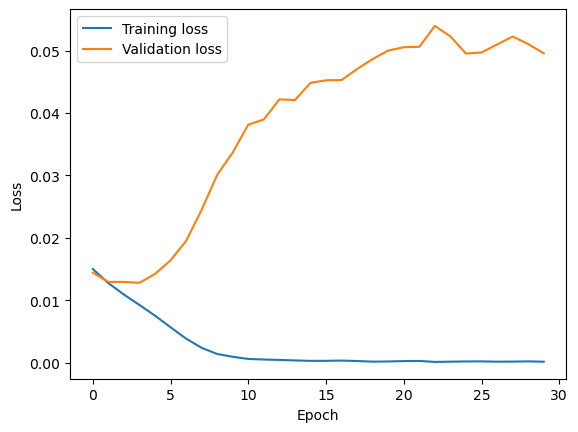

In [32]:
# 绘制训练和验证损失曲线
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

len(train_loader.dataset)：这表示数据集中的总样本数。使用这个作为分母，意味着你在计算整个数据集上的平均损失，每个样本的损失都计入平均值。这通常用于计算每个样本的平均损失，特别是在评估和测试模型性能时更为常见。

len(train_loader)：这表示批次的总数。由于每个批次包含多个样本（取决于你设置的batch_size），这个分母通常用于计算每个批次的平均损失。如果你的目的是观察批次间损失的变化，这种方法可能更合适。

In [22]:
len(train_loader.dataset),len(train_loader)

(45615, 713)